## Packages and Libraries

In [1]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold , cross_val_score, GridSearchCV
from classification_utilities import display_cm, display_adj_cm
from sklearn.metrics import confusion_matrix, f1_score, r2_score
from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.multiclass import OneVsOneClassifier
from scipy.signal import medfilt

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import matplotlib.colors as colors
from sklearn.metrics import plot_confusion_matrix

import xgboost as xgb
from xgboost.sklearn import  XGBClassifier
from hyperopt import STATUS_OK, fmin, hp, tpe
from sklearn.ensemble import RandomForestRegressor

import data_augmentation as dtaug
import plot_faceis as pltf
import classification_utilities as clf_util

## Input data

In [2]:
well0 = 'CHURCHMAN BIBLE'

#Load Data
input_data = pd.read_csv('facies_vectors.csv')

test = input_data[input_data['Well Name'] == well0]
data = input_data[input_data['Well Name'] != well0]
input_data = input_data[input_data['Well Name'] != well0]

out1 = data[data['Well Name'] == 'ALEXANDER D']
data = data[data['Well Name'] != 'ALEXANDER D']

out2 = data[data['Well Name'] == 'KIMZEY A']
data = data[data['Well Name'] != 'KIMZEY A']

mean_PE=np.nanmean(input_data[input_data['Well Name'] == 'Recruit F9'].PE.values)
data=data.replace(np.nan,mean_PE)
input_data=input_data.replace(np.nan,mean_PE)

# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']
feature_names2 = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

# Store features and labels
X = data[feature_names].values 
y = data['PE'].values 

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

#facies
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

## Data augmentation

In [3]:
X_aug,feature_names_aug=dtaug.augment_regre(X, well, depth,feature_names)

data_aug=pd.DataFrame(X_aug,columns=feature_names_aug)
data_aug['Well Name'],data_aug['Depth'],data_aug['Facies'] = [well, depth,data['Facies'].values]

#X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.25, random_state=42)

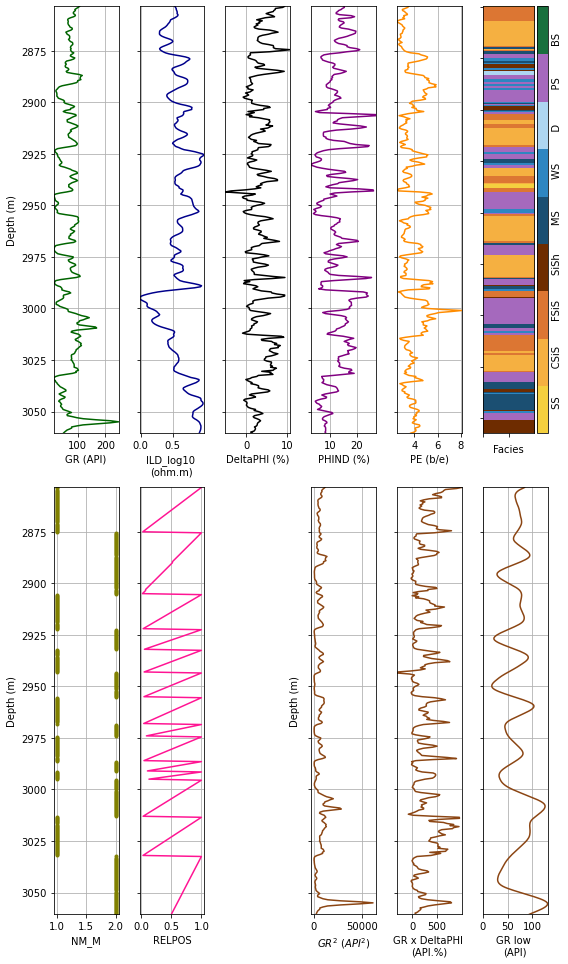

In [4]:
logs = data_aug.copy()
logs['PE']=data['PE'].values

pltf.plot1(logs[logs['Well Name'] == 'NOLAN'],facies_colors)
#plt.savefig('figures/figure4.png',dpi=500, bbox_inches='tight')

## Random Forest 

In [5]:
# configure the cross-validation procedure
cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
# define the model
est_reg = RandomForestRegressor(random_state=1,max_features='sqrt')
# define search space
param_grid = {'n_estimators':np.arange(80,101,2), 
'max_depth':np.arange(15,25,1)}

# define search
search = GridSearchCV(estimator=est_reg, param_grid=param_grid,
                      scoring='r2', n_jobs=-1, cv=cv_inner,
                       verbose=1, refit=True)

In [6]:
# configure the cross-validation procedure
groups = data['Well Name']
#cv_outer = LeaveOneGroupOut()

cv_outer = KFold(n_splits=7, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X_aug, y, groups=groups, scoring='r2', cv=cv_outer, n_jobs=-1,verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  3.1min finished


In [7]:
# report performance
print('Scores:',(scores),'\n')
print('R2: mean:%.3f (+/- %.3f)' % (np.mean(scores), np.std(scores)))

Scores: [0.8005699  0.78151147 0.79644391 0.81510202 0.82357644 0.82838525
 0.82179325] 

R2: mean:0.810 (+/- 0.016)


In [8]:
search.fit(X_aug,y)
best_parameters = search.best_params_
print(best_parameters)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 110 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   28.2s finished


{'max_depth': 17, 'n_estimators': 100}


In [9]:
# Prepare training data
X_tr = X_aug
y_tr = y

# Prepare test data
well_ts = test['Well Name'].values
depth_ts = test['Depth'].values
X_ts = test[feature_names].values

# Augment features
X_ts,_=dtaug.augment_regre(X_ts, well_ts, depth_ts,feature_names)

y_ts_hat=search.predict(X_ts)
test['Predicted_PE'] = y_ts_hat 

In [10]:
score = r2_score (test['PE'].values, test['Predicted_PE'].values)
print("Score: %0.2f"%(score))

Score: 0.72


C:\Users\felip\Google Drive\GitHub\coisas_privado\ML_SBGf_gas\plot_faceis.py:235: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  loc = 'upper center', ncol=5, bbox_to_anchor = (0.05,0.03,1,1))


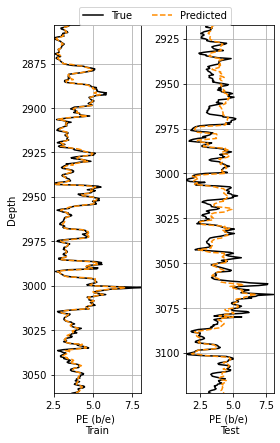

In [11]:
well_name_plot = 'NOLAN'
pltf.regression(data_aug,data,well_name_plot,search,test)

In [12]:
est_reg = RandomForestRegressor(random_state=1,max_features='sqrt',max_depth=17,n_estimators=100)
est_reg.fit(X_aug,y)
y_ts_hat2=est_reg.predict(X_ts)

In [13]:
feature_importance = est_reg.feature_importances_

result = permutation_importance(est_reg, X_ts, y_ts_hat2, n_repeats=10,
                                random_state=1, n_jobs=1)

#pltf.importance(feature_importance,result,data_aug)

C:\Users\felip\Google Drive\GitHub\coisas_privado\ML_SBGf_gas\plot_faceis.py:389: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax2.legend([log1.PE,log1.Predicted_PE], labels=['True','Predicted'])
C:\Users\felip\Google Drive\GitHub\coisas_privado\ML_SBGf_gas\plot_faceis.py:405: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax3.legend([log2.PE,log2.Predicted_PE], labels=['True','Predicted'])


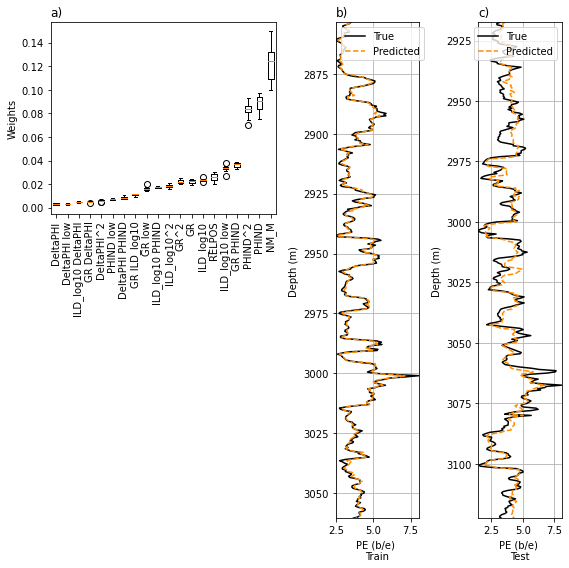

In [14]:
well_name_plot = 'NOLAN'

pltf.plot_figure5(data_aug,data,well_name_plot,est_reg,test,result)

#plt.savefig('figures/figure5.png',dpi=500, bbox_inches='tight')

## Predict and attribute PE into missing wells

In [15]:
X_ts,_=dtaug.augment_regre(out1[feature_names].values, out1['Well Name'], \
                              out1['Depth'].values,feature_names)

input_data.loc[input_data.index[input_data['Well Name']=='ALEXANDER D'], \
               'PE'] = search.predict(X_ts)

X_ts,_=dtaug.augment_regre(out2[feature_names].values, out2['Well Name'], \
                              out2['Depth'].values,feature_names)

input_data.loc[input_data.index[input_data['Well Name'] =='KIMZEY A'], \
               'PE'] = search.predict(X_ts)